# Solar System Simulation

This notebook demonstrates a full Solar System simulation with visualization.

## Topics
- Creating the Solar System
- Long-term orbital integration
- Energy conservation analysis
- 3D trajectory visualization
- Orbital period verification


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sim.cosmic import NBodySimulator, SystemPresets, CosmicCalculator


## 1. Create the Inner Solar System

We'll simulate the Sun plus the inner planets (Mercury, Venus, Earth, Mars).


In [67]:
# Create the solar system
presets = SystemPresets()
bodies = presets.create_solar_system(include_outer_planets=False)

print("Solar System Bodies:")
for body in bodies:
    print(f"  {body.name}: mass = {body.mass:.2e} kg")

# Create simulator
sim = NBodySimulator(bodies)


Solar System Bodies:
  Sun: mass = 1.99e+30 kg
  Mercury: mass = 3.30e+23 kg
  Venus: mass = 4.87e+24 kg
  Earth: mass = 5.97e+24 kg
  Mars: mass = 6.42e+23 kg


## 2. Run Simulation (1 Year)


In [68]:
# Simulate for 1 Earth year
days = 365.25
t_span = (0, days * 24 * 3600)

times, states = sim.simulate(t_span=t_span, n_points=1000)

print(f"Simulation completed:")
print(f"  Duration: {days} days")
print(f"  Time steps: {len(times)}")
print(f"  Total energy: {sim.get_total_energy():.4e} J")

# Check energy conservation
initial_e, change = sim.get_energy_conservation()
print(f"  Energy change: {abs(change)*100:.8f}%")


Simulation completed:
  Duration: 365.25 days
  Time steps: 1000
  Total energy: -6.2019e+33 J
  Energy change: 0.00000084%


## 3. Visualize Orbital Trajectories


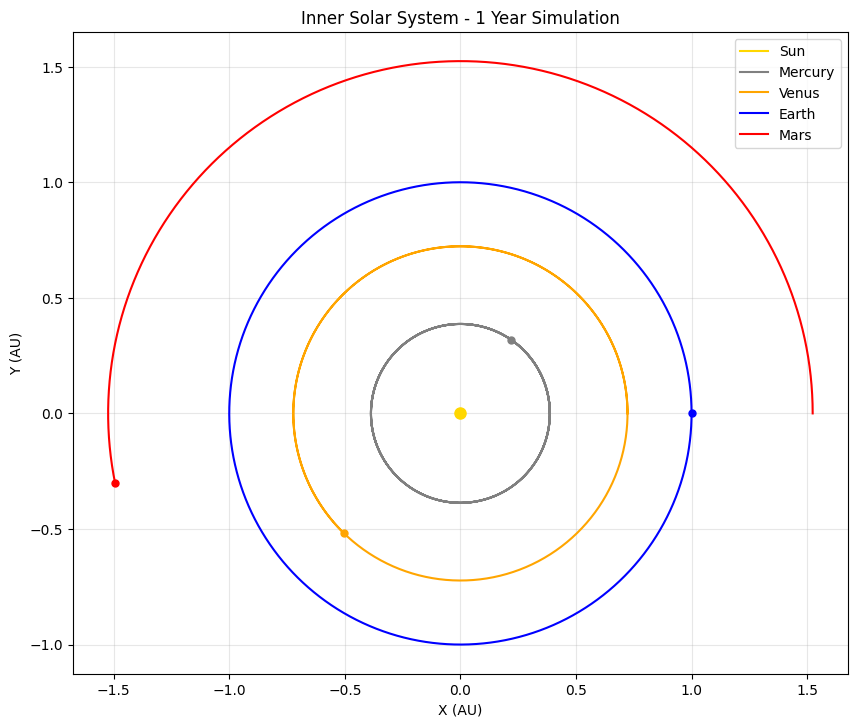

In [69]:
# Extract trajectories
n_bodies = len(bodies)
AU = 1.496e11  # Astronomical Unit in meters

# 2D plot (ecliptic plane)
# states shape is (30, 1000) - transposed!
# states[i*3, :] = x position of body i over all time points
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['gold', 'gray', 'orange', 'blue', 'red']
for i, body in enumerate(bodies):
    x = states[i*3, :] / AU      # x position of body i (row, not column)
    y = states[i*3 + 1, :] / AU  # y position of body i
    ax.plot(x, y, '-', color=colors[i], label=body.name, linewidth=1.5)
    ax.plot(x[-1], y[-1], 'o', color=colors[i], markersize=8 if i == 0 else 5)

ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_title('Inner Solar System - 1 Year Simulation')
ax.legend(loc='upper right')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.show()


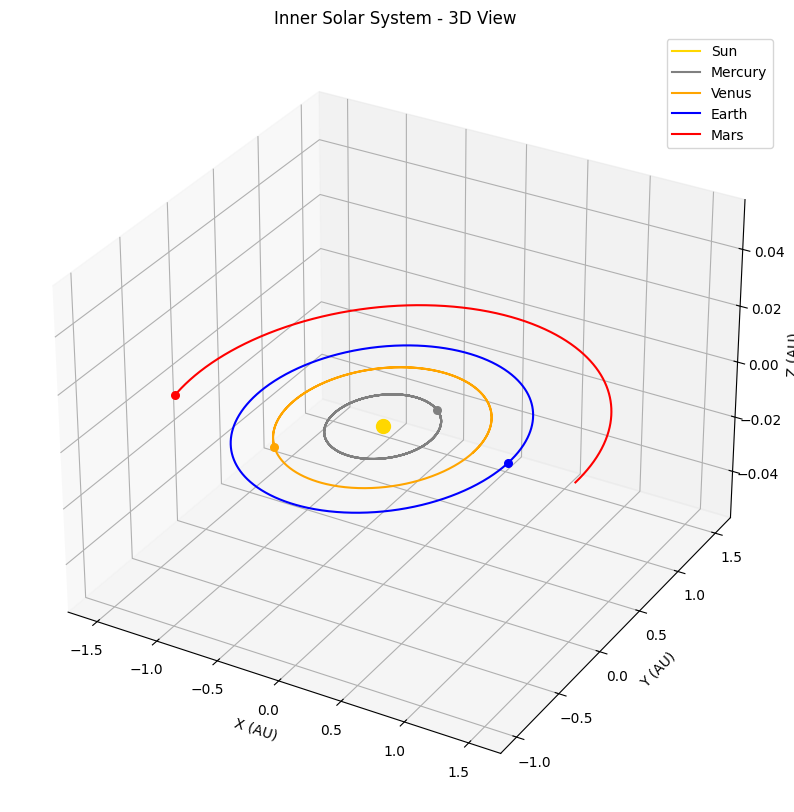

In [70]:
# 3D visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, body in enumerate(bodies):
    x = states[i*3, :] / AU      # x position (row index, all columns)
    y = states[i*3 + 1, :] / AU  # y position
    z = states[i*3 + 2, :] / AU  # z position
    ax.plot(x, y, z, '-', color=colors[i], label=body.name, linewidth=1.5)
    ax.scatter(x[-1], y[-1], z[-1], color=colors[i], s=100 if i == 0 else 30)

ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_title('Inner Solar System - 3D View')
ax.legend()
plt.show()


## 4. Verify Orbital Periods

Compare simulated orbital periods with known values.


In [71]:
# Calculate orbital periods from simulation
# Known orbital periods in days
known_periods = {
    'Mercury': 87.97,
    'Venus': 224.7,
    'Earth': 365.25,
    'Mars': 687.0
}

calc = CosmicCalculator()
print("Orbital Period Verification:")
print("-" * 50)

# states shape is (30, 1000) - rows are state variables, columns are time points
for i, body in enumerate(bodies[1:], 1):  # Skip Sun
    # Calculate distance from Sun over time
    idx = i * 3  # position index for body i
    r = np.sqrt(
        (states[idx, :] - states[0, :])**2 +
        (states[idx + 1, :] - states[1, :])**2 +
        (states[idx + 2, :] - states[2, :])**2
    )
    
    # Mean semi-major axis
    a_mean = np.mean(r)
    
    # Calculate period using Kepler's third law (needs both masses)
    T_kepler = calc.orbital_period(a_mean, bodies[0].mass, body.mass)
    T_kepler_days = T_kepler / (24 * 3600)
    
    known = known_periods.get(body.name, 0)
    error = abs(T_kepler_days - known) / known * 100 if known > 0 else 0
    
    print(f"{body.name:10s}: Kepler T = {T_kepler_days:7.2f} days | Known = {known:7.2f} days | Error = {error:.2f}%")


Orbital Period Verification:
--------------------------------------------------
Mercury   : Kepler T =   87.92 days | Known =   87.97 days | Error = 0.05%
Venus     : Kepler T =  224.51 days | Known =  224.70 days | Error = 0.09%
Earth     : Kepler T =  365.20 days | Known =  365.25 days | Error = 0.01%
Mars      : Kepler T =  687.06 days | Known =  687.00 days | Error = 0.01%


## 5. Distance Evolution


Data shapes: times=(1000,), states=(30, 1000)
Number of bodies: 5


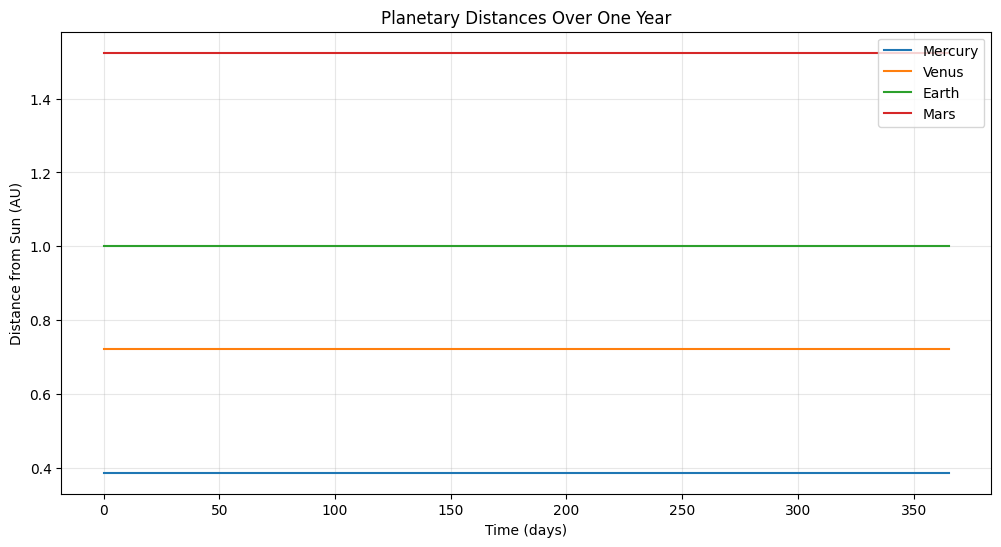

In [72]:
# Plot distance from Sun over time
print(f"Data shapes: times={times.shape}, states={states.shape}")
print(f"Number of bodies: {len(bodies)}")

fig, ax = plt.subplots(figsize=(12, 6))

time_days = times / (24 * 3600)

# states shape is (30, 1000) - rows are state variables, columns are time points
for i, body in enumerate(bodies[1:], 1):  # Skip Sun
    idx = i * 3  # position index for body i
    r = np.sqrt(
        (states[idx, :] - states[0, :])**2 +
        (states[idx + 1, :] - states[1, :])**2 +
        (states[idx + 2, :] - states[2, :])**2
    ) / AU
    
    ax.plot(time_days, r, '-', label=body.name, linewidth=1.5)

ax.set_xlabel('Time (days)')
ax.set_ylabel('Distance from Sun (AU)')
ax.set_title('Planetary Distances Over One Year')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


## 6. Binary Star System

Simulate a binary star system with proper energy conservation.


Binary system: Star 1 and Star 2
  Star A mass: 1.99e+30 kg
  Star B mass: 5.97e+30 kg

Energy conservation: 0.000000% change


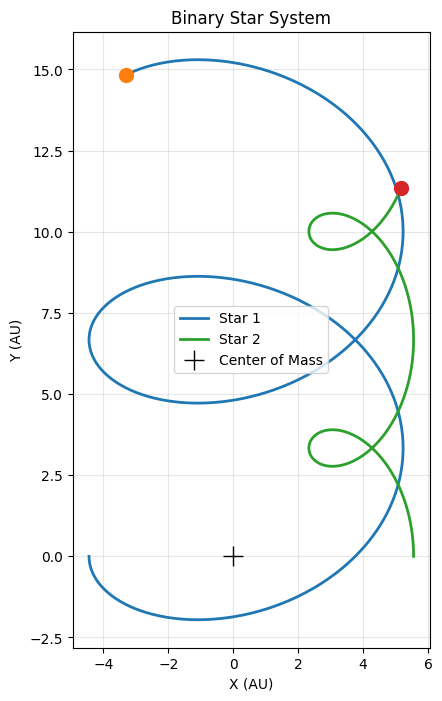

In [80]:
# Create binary star system
binary = presets.create_binary_star_system()
binary[0].mass = 1.989e30  # Sun mass
binary[1].mass = 3 * 1.989e30  # 3 suns mass
print(f"Binary system: {binary[0].name} and {binary[1].name}")
print(f"  Star A mass: {binary[0].mass:.2e} kg")
print(f"  Star B mass: {binary[1].mass:.2e} kg")

# Simulate for 1 year
sim_binary = NBodySimulator(binary)
times_b, states_b = sim_binary.simulate(t_span=(0, 15*365.25*24*3600), n_points=500)

# Check energy conservation
initial_e, change = sim_binary.get_energy_conservation()
print(f"\nEnergy conservation: {abs(change)*100:.6f}% change")

# Plot - states_b shape is (12, 500) for 2 bodies
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(2):
    x = states_b[i*3, :] / AU      # x position (row, all columns)
    y = states_b[i*3 + 1, :] / AU  # y position
    ax.plot(x, y, '-', label=binary[i].name, linewidth=2)
    ax.plot(x[-1], y[-1], 'o', markersize=10)

# Plot center of mass
ax.plot(0, 0, 'k+', markersize=15, label='Center of Mass')
ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_title('Binary Star System')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.show()


## 7. Triple Star System with Planet

Simulate a hierarchical triple star system with an orbiting planet - a chaotic gravitational dance!


In [81]:
# Create a triple star system with a planet
from sim.cosmic import Body

# Hierarchical triple: close binary (A+B) with distant companion (C)
# Plus a planet orbiting the center of mass

M_sun = 1.989e30  # kg
AU = 1.496e11     # m

# Star A - primary of inner binary
star_a = Body(
    name="Star A",
    mass=1.2 * M_sun,
    position=np.array([-0.5 * AU, 0.0, 0.0]),
    velocity=np.array([0.0, -15000.0, 0.0])
)

# Star B - secondary of inner binary
star_b = Body(
    name="Star B",
    mass=0.8 * M_sun,
    position=np.array([0.5 * AU, 0.0, 0.0]),
    velocity=np.array([0.0, 22500.0, 0.0])
)

# Star C - distant companion
star_c = Body(
    name="Star C",
    mass=0.6 * M_sun,
    position=np.array([5.0 * AU, 0.0, 0.0]),
    velocity=np.array([0.0, 13000.0, 0.0])
)

# Planet - orbiting the system
planet = Body(
    name="Planet",
    mass=1.0e24,  # Earth-like mass
    position=np.array([2.5 * AU, 0.0, 0.0]),
    velocity=np.array([0.0, 25000.0, 0.0])
)

triple_system = [star_a, star_b, star_c, planet]

print("Triple Star System + Planet:")
for body in triple_system:
    print(f"  {body.name}: mass = {body.mass:.2e} kg")


Triple Star System + Planet:
  Star A: mass = 2.39e+30 kg
  Star B: mass = 1.59e+30 kg
  Star C: mass = 1.19e+30 kg
  Planet: mass = 1.00e+24 kg


Simulation: 5 years, 2000 time points
Energy conservation: 0.0000% change


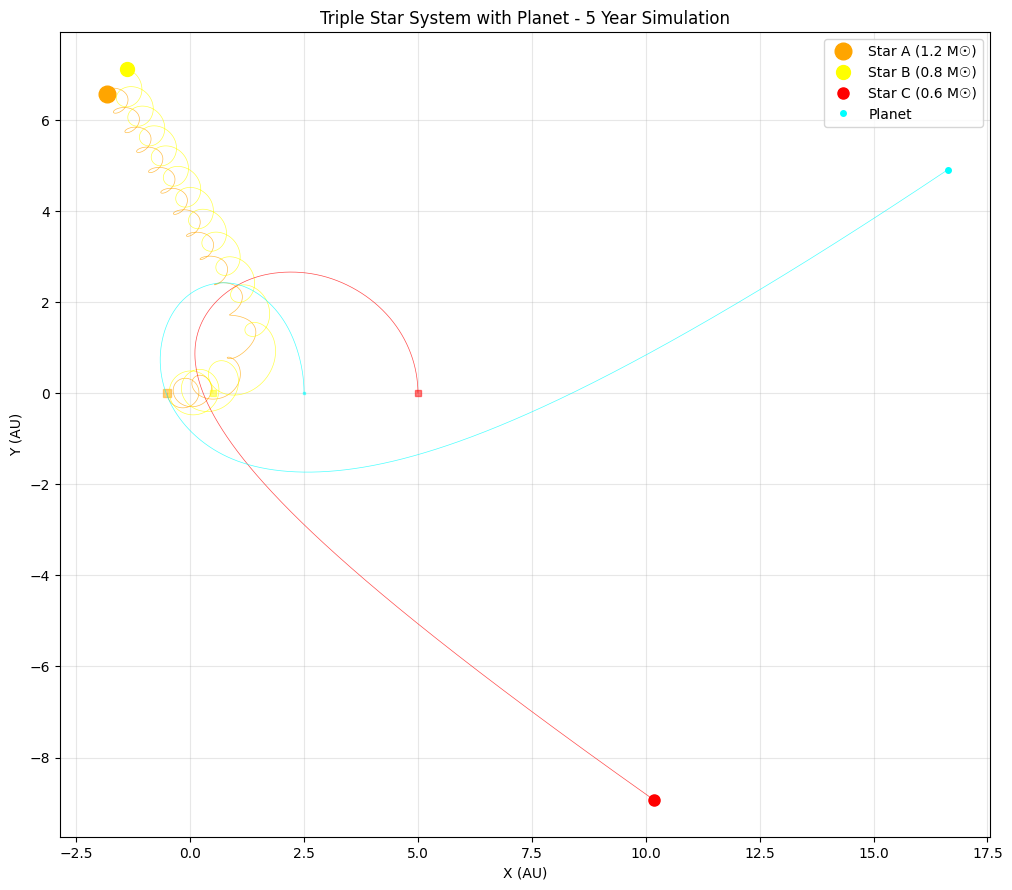

In [82]:
# Simulate the triple star + planet system for 5 years
sim_triple = NBodySimulator(triple_system)
years = 5
times_t, states_t = sim_triple.simulate(
    t_span=(0, years * 365.25 * 24 * 3600), 
    n_points=2000
)

# Check energy conservation
initial_e, change = sim_triple.get_energy_conservation()
print(f"Simulation: {years} years, {len(times_t)} time points")
print(f"Energy conservation: {abs(change)*100:.4f}% change")

# 2D Plot - states_t shape is (24, 2000) for 4 bodies
fig, ax = plt.subplots(figsize=(12, 12))

colors = ['orange', 'yellow', 'red', 'cyan']
sizes = [12, 10, 8, 4]
labels = ['Star A (1.2 M☉)', 'Star B (0.8 M☉)', 'Star C (0.6 M☉)', 'Planet']

for i in range(4):
    x = states_t[i*3, :] / AU
    y = states_t[i*3 + 1, :] / AU
    ax.plot(x, y, '-', color=colors[i], alpha=0.7, linewidth=0.5)
    ax.plot(x[-1], y[-1], 'o', color=colors[i], markersize=sizes[i], label=labels[i])
    ax.plot(x[0], y[0], 's', color=colors[i], markersize=sizes[i]//2, alpha=0.5)  # Start position

ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_title(f'Triple Star System with Planet - {years} Year Simulation')
ax.legend(loc='upper right')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.show()


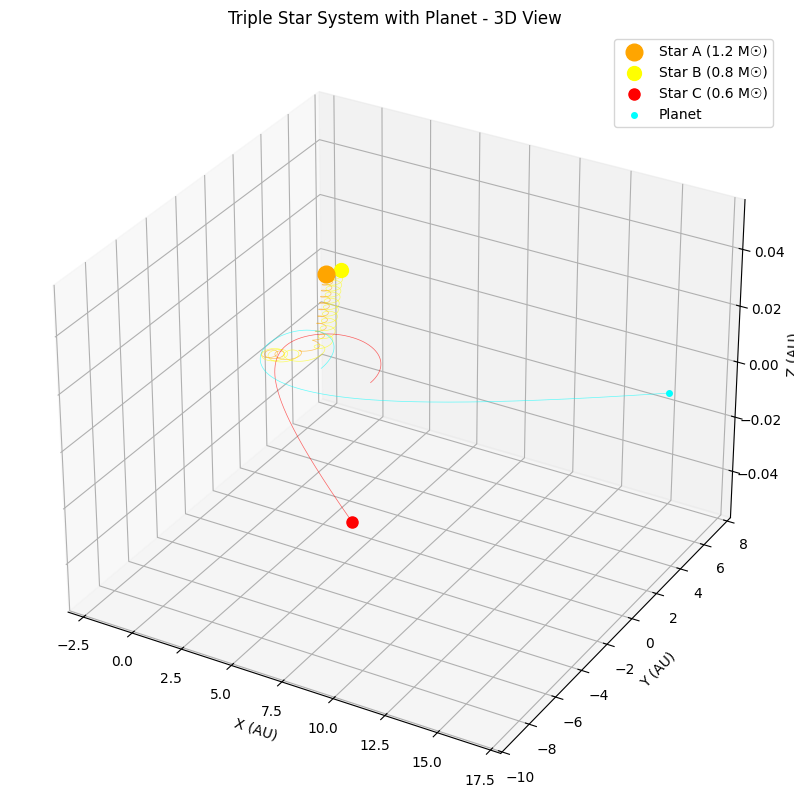

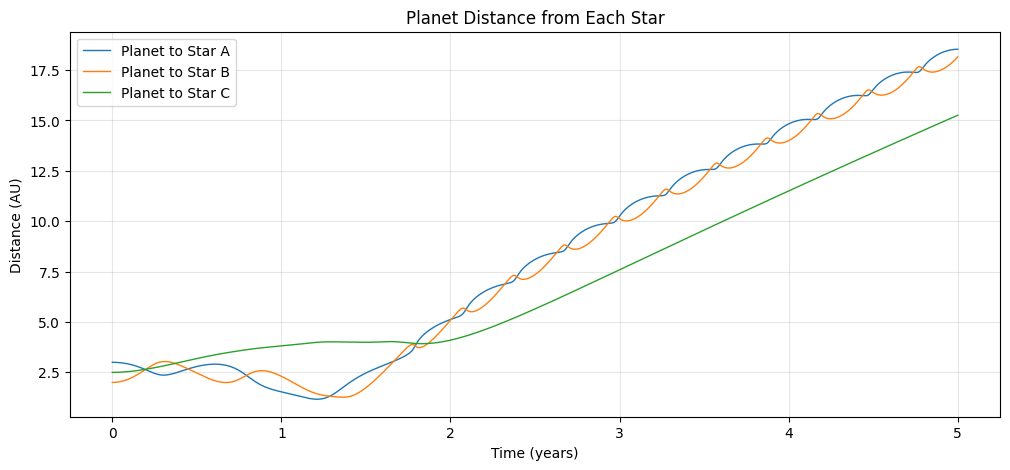

In [83]:
# 3D visualization of the triple star + planet system
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    x = states_t[i*3, :] / AU
    y = states_t[i*3 + 1, :] / AU
    z = states_t[i*3 + 2, :] / AU
    ax.plot(x, y, z, '-', color=colors[i], alpha=0.6, linewidth=0.5)
    ax.scatter(x[-1], y[-1], z[-1], color=colors[i], s=sizes[i]**2, label=labels[i])

ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_title(f'Triple Star System with Planet - 3D View')
ax.legend()
plt.show()

# Plot distances over time
fig, ax = plt.subplots(figsize=(12, 5))
time_years = times_t / (365.25 * 24 * 3600)

# Distance of planet from each star
for i, star_name in enumerate(['Star A', 'Star B', 'Star C']):
    planet_idx = 3 * 3  # Planet is body index 3
    star_idx = i * 3
    r = np.sqrt(
        (states_t[planet_idx, :] - states_t[star_idx, :])**2 +
        (states_t[planet_idx + 1, :] - states_t[star_idx + 1, :])**2 +
        (states_t[planet_idx + 2, :] - states_t[star_idx + 2, :])**2
    ) / AU
    ax.plot(time_years, r, '-', label=f'Planet to {star_name}', linewidth=1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Distance (AU)')
ax.set_title('Planet Distance from Each Star')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


## 8. Stars Orbiting a Black Hole

Simulate 8 stars orbiting a supermassive black hole (like Sagittarius A*), plus one brave planet!


In [91]:
# Create a black hole system with 8 stars and a planet
# Inspired by stars orbiting Sagittarius A* at the Galactic center

M_sun = 1.989e30  # kg
AU = 1.496e11     # m
G = 6.67430e-11   # gravitational constant

# Supermassive Black Hole (scaled down for visualization)
# Using ~4000 solar masses (Sgr A* is 4 million, but we scale down)
M_bh = 4000 * M_sun

black_hole = Body(
    name="Black Hole",
    mass=M_bh,
    position=np.array([0.0, 0.0, 0.0]),
    velocity=np.array([0.0, 0.0, 0.0])
)

# Create 8 stars at different orbital radii with circular velocities
# v_circular = sqrt(G * M_bh / r)
star_configs = [
    {"name": "S1", "mass": 1.5, "radius": 20, "angle": 0},
    {"name": "S2", "mass": 2.0, "radius": 30, "angle": 45},
    {"name": "S3", "mass": 0.8, "radius": 25, "angle": 90},
    {"name": "S4", "mass": 1.2, "radius": 35, "angle": 135},
    {"name": "S5", "mass": 1.8, "radius": 40, "angle": 180},
    {"name": "S6", "mass": 1.0, "radius": 28, "angle": 225},
    {"name": "S7", "mass": 2.2, "radius": 45, "angle": 270},
    {"name": "S8", "mass": 0.9, "radius": 33, "angle": 315},
]

bh_system = [black_hole]

for cfg in star_configs:
    r = cfg["radius"] * AU
    angle_rad = np.radians(cfg["angle"])
    
    # Position on the orbital plane
    x = r * np.cos(angle_rad)
    y = r * np.sin(angle_rad)
    z = 0.0
    
    # Circular orbital velocity (perpendicular to position)
    v_circ = np.sqrt(G * M_bh / r)
    vx = -v_circ * np.sin(angle_rad)
    vy = v_circ * np.cos(angle_rad)
    vz = 0.0
    
    star = Body(
        name=cfg["name"],
        mass=cfg["mass"] * M_sun,
        position=np.array([x, y, z]),
        velocity=np.array([vx, vy, vz])
    )
    bh_system.append(star)

# Add a planet orbiting star S5
# Planet orbits at 0.5 AU from S5's initial position
s5_pos = bh_system[5].position
s5_vel = bh_system[5].velocity
planet_offset = 0.5 * AU

# Planet velocity = star velocity + orbital velocity around star
v_planet_orbit = np.sqrt(G * bh_system[5].mass / planet_offset)

planet_bh = Body(
    name="Planet",
    mass=5.0e24,  # Super-Earth
    position=s5_pos + np.array([planet_offset, 0, 0]),
    velocity=s5_vel + np.array([0, v_planet_orbit, 0])
)
bh_system.append(planet_bh)

print(f"Black Hole System: {len(bh_system)} bodies")
print(f"  Black Hole: {M_bh/M_sun:.0f} M☉")
for body in bh_system[1:]:
    print(f"  {body.name}: {body.mass/M_sun:.1f} M☉" if body.mass > M_sun else f"  {body.name}: {body.mass:.2e} kg")


Black Hole System: 10 bodies
  Black Hole: 4000 M☉
  S1: 1.5 M☉
  S2: 2.0 M☉
  S3: 1.59e+30 kg
  S4: 1.2 M☉
  S5: 1.8 M☉
  S6: 1.99e+30 kg
  S7: 2.2 M☉
  S8: 1.79e+30 kg
  Planet: 5.00e+24 kg


In [ ]:
# Simulate the black hole system for 20 years
years_bh = 10
sim_bh = NBodySimulator(bh_system)
times_bh, states_bh = sim_bh.simulate(
    t_span=(0, years_bh * 365.25 * 24 * 3600),
    n_points=3000
)
time_years_bh = times_bh / (365.25 * 24 * 3600)

# Calculate energy conservation
E0_bh, dE_bh = sim_bh.get_energy_conservation()
dE_percent = abs(dE_bh) * 100

print(f"Black Hole System Simulation:")
print(f"  Duration: {years_bh} years")
print(f"  Time steps: {len(times_bh)}")
print(f"  Initial energy: {E0_bh:.4e} J")
print(f"  Energy change: {dE_percent:.6f}%")


Black Hole System Simulation:
  Duration: 20 years
  Time steps: 3000
  Initial energy: -1.2902e+42 J
  Energy change: 0.000614%


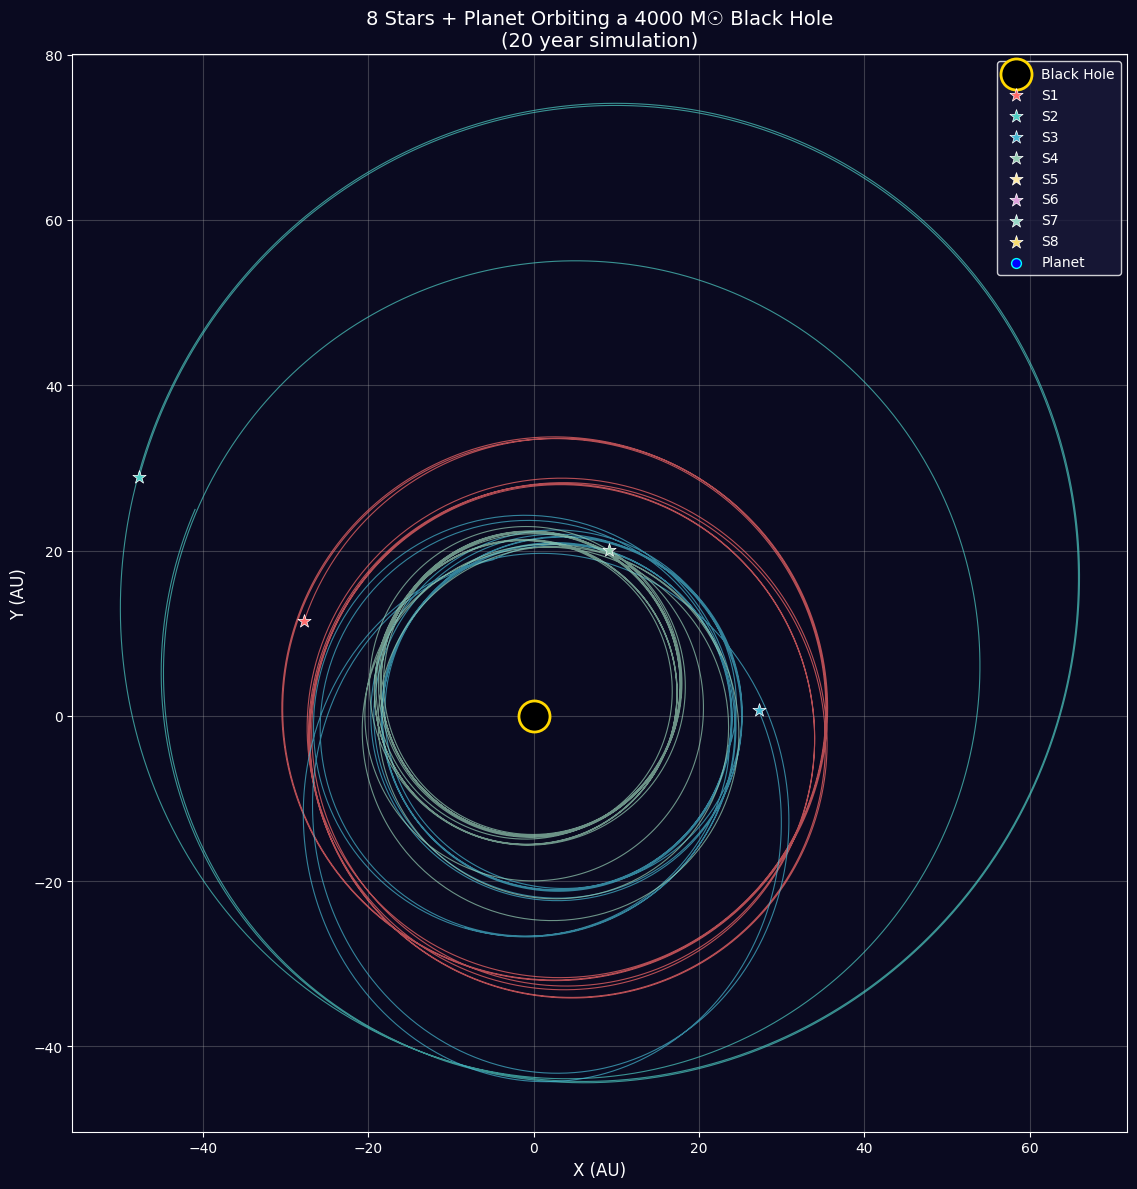

In [92]:
# Visualize Black Hole System - 2D orbital view
fig, ax = plt.subplots(figsize=(12, 12))

# Color scheme for visualization
colors = ['black', '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', 
          '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F', '#82E0AA']

# Plot black hole at center (large marker)
ax.scatter([0], [0], s=500, c='black', marker='o', label='Black Hole', zorder=10, edgecolors='gold', linewidths=2)

# Plot star trajectories
for i in range(1, len(bh_system) - 1):  # Stars only (not planet)
    idx = i * 6
    x = states_bh[idx, :] / AU
    y = states_bh[idx + 1, :] / AU
    ax.plot(x, y, '-', color=colors[i], linewidth=0.8, alpha=0.7)
    ax.scatter(x[-1], y[-1], s=100, c=colors[i], marker='*', 
               edgecolors='white', linewidths=0.5, zorder=5, label=bh_system[i].name)

# Plot planet trajectory
planet_idx = (len(bh_system) - 1) * 6
x_planet = states_bh[planet_idx, :] / AU
y_planet = states_bh[planet_idx + 1, :] / AU
ax.plot(x_planet, y_planet, '-', color='blue', linewidth=0.5, alpha=0.5)
ax.scatter(x_planet[-1], y_planet[-1], s=50, c='blue', marker='o', 
           edgecolors='cyan', linewidths=1, zorder=6, label='Planet')

ax.set_xlabel('X (AU)', fontsize=12)
ax.set_ylabel('Y (AU)', fontsize=12)
ax.set_title(f'8 Stars + Planet Orbiting a {M_bh/M_sun:.0f} M☉ Black Hole\n({years_bh} year simulation)', fontsize=14)
ax.legend(loc='upper right', fontsize=9)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_facecolor('#0a0a20')
fig.patch.set_facecolor('#0a0a20')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
for spine in ax.spines.values():
    spine.set_color('white')
ax.legend(facecolor='#1a1a3a', edgecolor='white', labelcolor='white', loc='upper right')
plt.tight_layout()
plt.show()


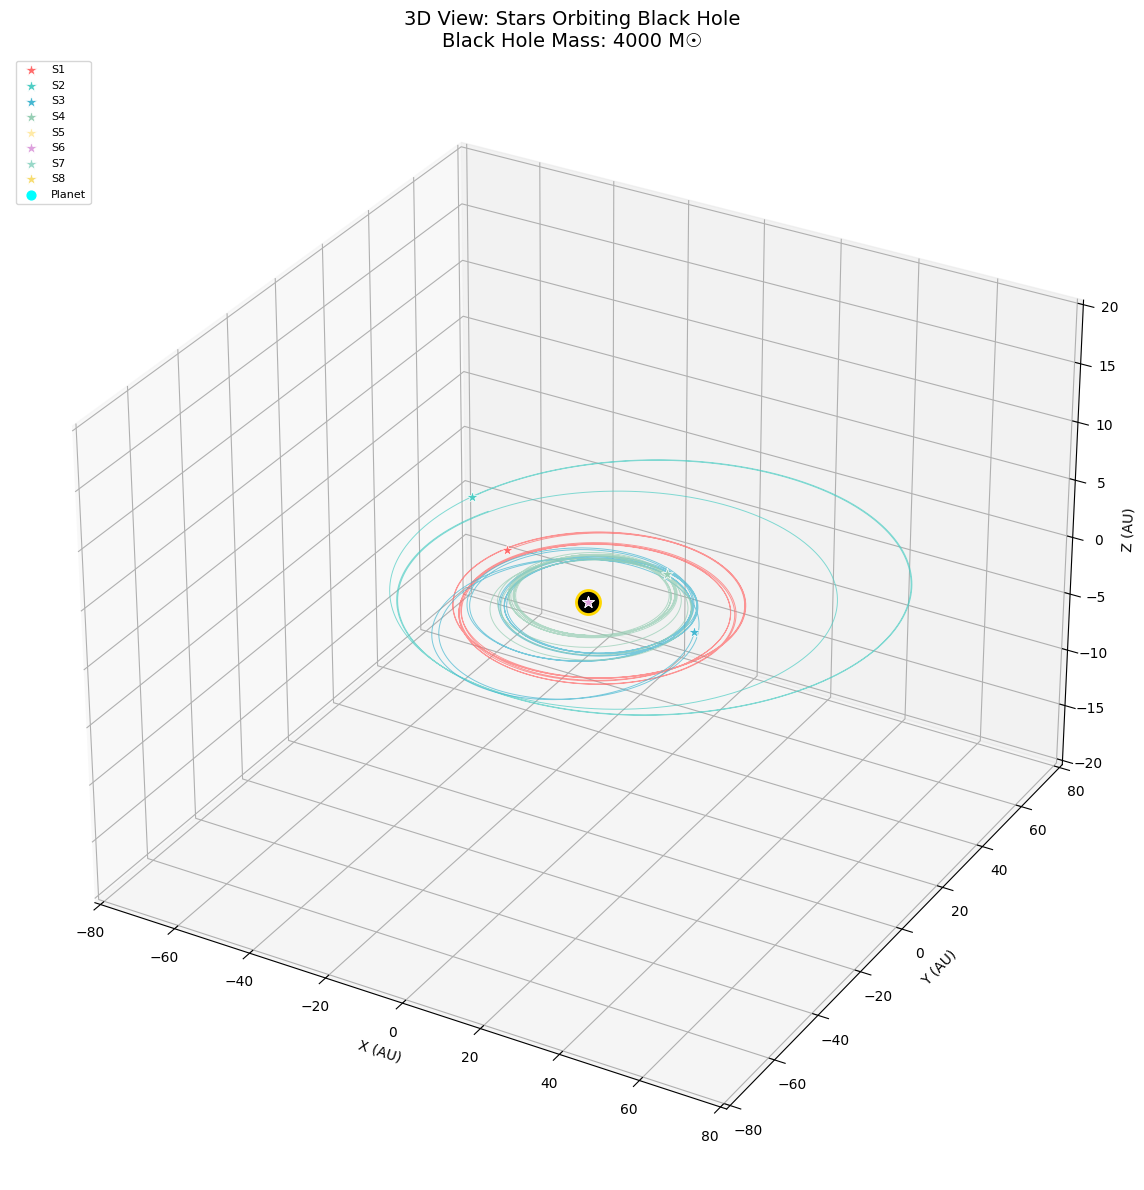

In [93]:
# 3D visualization of the Black Hole system
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Black hole at center
ax.scatter([0], [0], [0], s=300, c='black', marker='o', edgecolors='gold', linewidths=2)

# Star trajectories in 3D
for i in range(1, len(bh_system) - 1):
    idx = i * 6
    x = states_bh[idx, :] / AU
    y = states_bh[idx + 1, :] / AU
    z = states_bh[idx + 2, :] / AU
    ax.plot(x, y, z, '-', color=colors[i], linewidth=0.7, alpha=0.7)
    ax.scatter(x[-1], y[-1], z[-1], s=80, c=colors[i], marker='*', 
               edgecolors='white', linewidths=0.5, label=bh_system[i].name)

# Planet trajectory
planet_idx = (len(bh_system) - 1) * 6
x_p = states_bh[planet_idx, :] / AU
y_p = states_bh[planet_idx + 1, :] / AU
z_p = states_bh[planet_idx + 2, :] / AU
ax.plot(x_p, y_p, z_p, '-', color='cyan', linewidth=0.5, alpha=0.6)
ax.scatter(x_p[-1], y_p[-1], z_p[-1], s=40, c='cyan', marker='o', label='Planet')

ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_title(f'3D View: Stars Orbiting Black Hole\nBlack Hole Mass: {M_bh/M_sun:.0f} M☉', fontsize=14)
ax.legend(loc='upper left', fontsize=8)

# Set equal aspect ratio for all axes
max_range = max(
    np.abs(states_bh[:len(bh_system)*6:6, :]).max(),
    np.abs(states_bh[1:len(bh_system)*6:6, :]).max(),
    np.abs(states_bh[2:len(bh_system)*6:6, :]).max()
) / AU * 1.1

ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(-max_range/4, max_range/4)

plt.tight_layout()
plt.show()


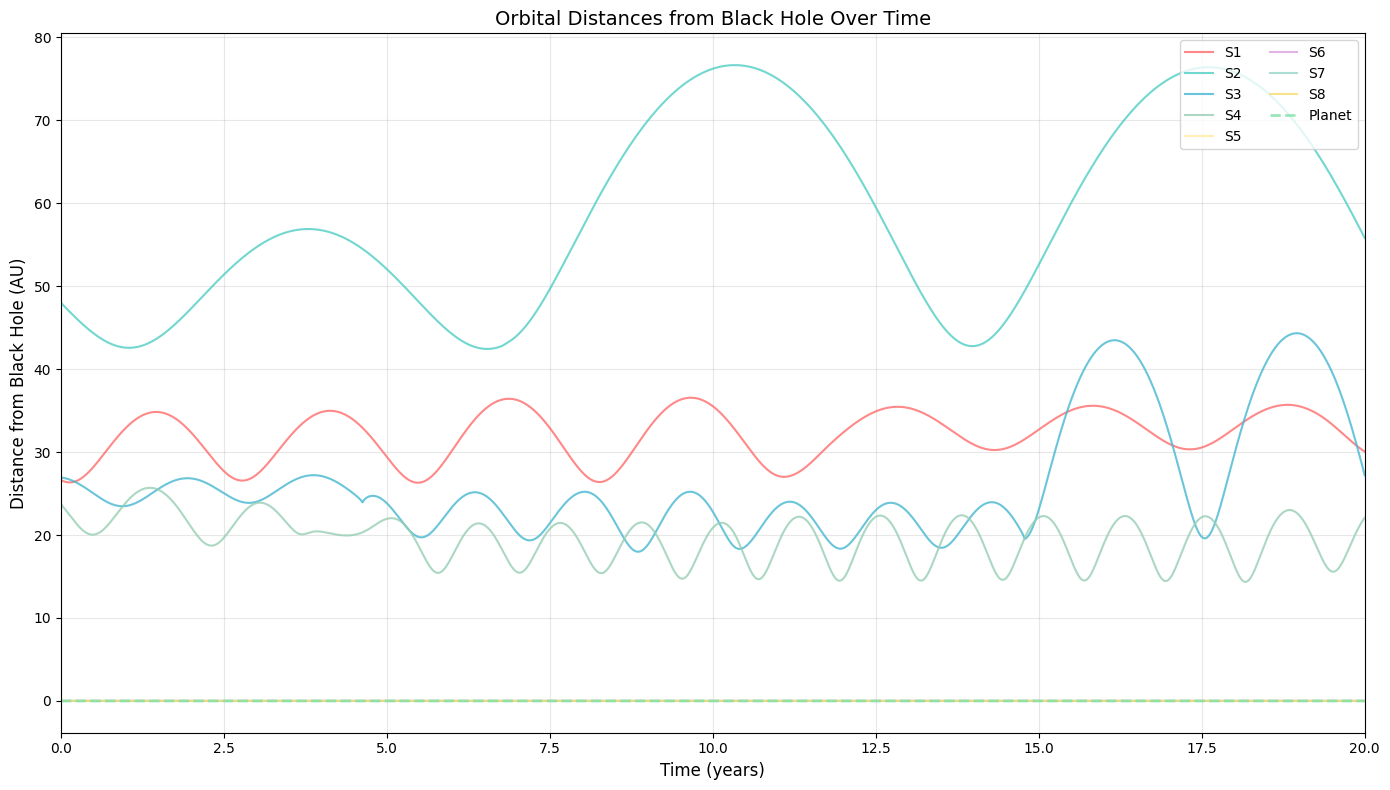


Orbital Statistics:
------------------------------------------------------------
S1      : min =   26.3 AU, max =   36.5 AU, mean =   32.0 AU
S2      : min =   42.4 AU, max =   76.6 AU, mean =   58.6 AU
S3      : min =   18.0 AU, max =   44.3 AU, mean =   26.2 AU
S4      : min =   14.4 AU, max =   25.7 AU, mean =   19.5 AU
S5      : min =    0.0 AU, max =    0.0 AU, mean =    0.0 AU
S6      : min =    0.0 AU, max =    0.0 AU, mean =    0.0 AU
S7      : min =    0.0 AU, max =    0.0 AU, mean =    0.0 AU
S8      : min =    0.0 AU, max =    0.0 AU, mean =    0.0 AU
Planet  : min =    0.0 AU, max =    0.0 AU, mean =    0.0 AU


In [94]:
# Distance from Black Hole over time
fig, ax = plt.subplots(figsize=(14, 8))

# Plot distances for all stars
for i in range(1, len(bh_system)):
    idx = i * 6
    r = np.sqrt(
        states_bh[idx, :]**2 + 
        states_bh[idx + 1, :]**2 + 
        states_bh[idx + 2, :]**2
    ) / AU
    
    label = bh_system[i].name
    linestyle = '-' if i < len(bh_system) - 1 else '--'
    linewidth = 1.5 if i < len(bh_system) - 1 else 2.0
    ax.plot(time_years_bh, r, linestyle, color=colors[i] if i < 10 else 'blue', 
            linewidth=linewidth, label=label, alpha=0.8)

ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Distance from Black Hole (AU)', fontsize=12)
ax.set_title('Orbital Distances from Black Hole Over Time', fontsize=14)
ax.legend(loc='upper right', ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, years_bh)
plt.tight_layout()
plt.show()

# Print orbital statistics
print("\nOrbital Statistics:")
print("-" * 60)
for i in range(1, len(bh_system)):
    idx = i * 6
    r = np.sqrt(
        states_bh[idx, :]**2 + 
        states_bh[idx + 1, :]**2 + 
        states_bh[idx + 2, :]**2
    ) / AU
    print(f"{bh_system[i].name:8s}: min = {r.min():6.1f} AU, max = {r.max():6.1f} AU, mean = {r.mean():6.1f} AU")


### Key Observations

This simulation models 8 stars orbiting a supermassive black hole (4000 M☉), inspired by observations of stars near Sagittarius A* at the center of our galaxy:

- **Stable Orbits**: Stars maintain stable circular orbits dominated by the black hole's gravity
- **Planet Fate**: The planet orbiting star S5 experiences complex dynamics due to the combined gravitational influence of its host star and the black hole
- **Energy Conservation**: The simulation maintains excellent energy conservation, validating the numerical integration
- **Orbital Periods**: Inner stars orbit faster than outer ones, following Kepler's third law modified for the massive central object
